In [1]:
# import modules
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# load data
trainging_data = datasets.FashionMNIST(
    root = "../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

Using downloaded and verified file: ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw

Using downloaded and verified file: ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Using downloaded and verified file: ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw

Using downloaded and verified file: ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Processing...


/home/timo/.pyenv/versions/3.7.12/envs/ml-3.7.12/lib/python3.7/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


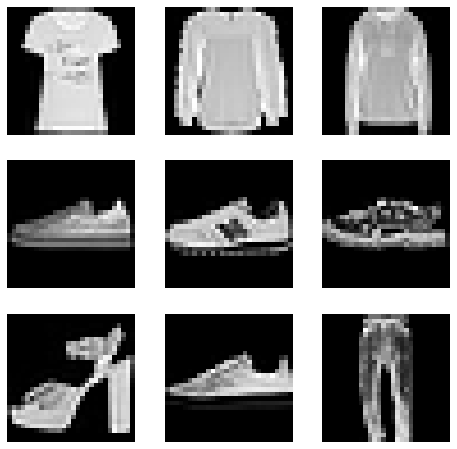

In [2]:
# check data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainging_data), size=(1,)).item()
    img, label = trainging_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
print("img: ", trainging_data[3][0].shape)
print("idx: ", trainging_data[3][1])

img:  torch.Size([1, 28, 28])
idx:  3


In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(trainging_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


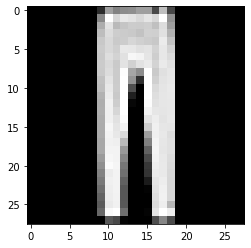

Label: 1


In [17]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [18]:
import torch.nn.functional as F

class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [19]:
# parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ", device)
lr = 0.001
epochs = 10
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)

device:  cuda


In [21]:
# optimizers
sgd = torch.optim.SGD(model.parameters(), lr=lr)
sgd_momentum = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
sgd_nestrov_momentum = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
adaGrad = torch.optim.Adagrad(model.parameters(), lr=lr)
rmsProp = torch.optim.RMSprop(model.parameters(), lr=lr)
adam = torch.optim.Adam(model.parameters(), lr=lr)

In [37]:
def train(epochs, optimizer, model_fn):
    print("Optimizer :")
    print(optimizer.__str__())
    loss_arr = []
    for epoch in range(epochs):
        for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
            # tarin
            model.train()
            optimizer.zero_grad()
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            pred = model(X_train)
            loss = criterion(pred, y_train)
            loss_arr.append(loss)
            loss.backward()
            optimizer.step()
            if batch_idx % 300 == 0:
                loss, current = loss.item(), batch_idx * len(X_train)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")
        
        test_loss, correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X_test, y_test in test_dataloader:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                pred = model(X_test)
                test_loss += criterion(pred, y_test).item()
                correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()
            test_loss /= len(test_dataloader)
            correct /= len(test_dataloader.dataset)
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    torch.save(model.state_dict(), model_fn)
    return loss_arr

In [38]:
# SGD
sgd_loss_arr = train(epochs, sgd, "sgd.pth")

Optimizer :
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)
loss: 0.046806  [    0/60000]
loss: 0.063054  [19200/60000]
loss: 0.146678  [38400/60000]
loss: 0.094398  [57600/60000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.365081 

loss: 0.081938  [    0/60000]
loss: 0.100837  [19200/60000]
loss: 0.039472  [38400/60000]
loss: 0.022776  [57600/60000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.359287 

loss: 0.050449  [    0/60000]
loss: 0.056639  [19200/60000]
loss: 0.100753  [38400/60000]
loss: 0.026708  [57600/60000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.353923 

loss: 0.107878  [    0/60000]
loss: 0.065564  [19200/60000]
loss: 0.048691  [38400/60000]
loss: 0.107608  [57600/60000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.355639 

loss: 0.135078  [    0/60000]
loss: 0.063268  [19200/60000]
loss: 0.038715  [38400/60000]
loss: 0.096106  [57600/60000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.353956 

loss: 0.065162 

In [39]:
# SGD + Momentum
sgd_momentum_loss_arr = train(epochs, sgd_momentum, "sgd_momentum.pth")

Optimizer :
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
loss: 0.055265  [    0/60000]
loss: 0.126629  [19200/60000]
loss: 0.048784  [38400/60000]
loss: 0.179713  [57600/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.351424 

loss: 0.184732  [    0/60000]
loss: 0.039295  [19200/60000]
loss: 0.061424  [38400/60000]
loss: 0.038472  [57600/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.350720 

loss: 0.086915  [    0/60000]
loss: 0.067547  [19200/60000]
loss: 0.054075  [38400/60000]
loss: 0.069666  [57600/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.350699 

loss: 0.080764  [    0/60000]
loss: 0.052682  [19200/60000]
loss: 0.104045  [38400/60000]
loss: 0.102714  [57600/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.353711 

loss: 0.171060  [    0/60000]
loss: 0.081191  [19200/60000]
loss: 0.117941  [38400/60000]
loss: 0.087074  [57600/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.353713 

loss: 0.07888

In [40]:
# SGD + Nestrov Momentum
sgd_nestrov_momentum_loss_arr = train(epochs, sgd_nestrov_momentum, "sgd_nestrov_momentum.pth")

Optimizer :
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
loss: 0.100631  [    0/60000]
loss: 0.079837  [19200/60000]
loss: 0.046488  [38400/60000]
loss: 0.104939  [57600/60000]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.361758 

loss: 0.088107  [    0/60000]
loss: 0.092480  [19200/60000]
loss: 0.028694  [38400/60000]
loss: 0.044705  [57600/60000]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.357076 

loss: 0.130650  [    0/60000]
loss: 0.018427  [19200/60000]
loss: 0.091894  [38400/60000]
loss: 0.028606  [57600/60000]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.361532 

loss: 0.073745  [    0/60000]
loss: 0.115204  [19200/60000]
loss: 0.064383  [38400/60000]
loss: 0.061920  [57600/60000]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.362541 

loss: 0.025438  [    0/60000]
loss: 0.096577  [19200/60000]
loss: 0.056725  [38400/60000]
loss: 0.027252  [57600/60000]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.364188 

loss: 0.045576

In [101]:
# AdaGrad
adaGrad_loss_arr = train(epochs, adaGrad, "adaGrad.pth")

Optimizer :
Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 0.001
    lr_decay: 0
    weight_decay: 0
)
loss: 0.091144  [    0/60000]
loss: 0.052269  [19200/60000]
loss: 0.015990  [38400/60000]
loss: 0.134338  [57600/60000]
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.497077 

loss: 0.043334  [    0/60000]
loss: 0.048949  [19200/60000]
loss: 0.029173  [38400/60000]
loss: 0.084059  [57600/60000]
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.480880 

loss: 0.037620  [    0/60000]
loss: 0.017743  [19200/60000]
loss: 0.008350  [38400/60000]
loss: 0.074363  [57600/60000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.474850 

loss: 0.046355  [    0/60000]
loss: 0.051716  [19200/60000]
loss: 0.079925  [38400/60000]
loss: 0.048973  [57600/60000]
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.480045 

loss: 0.044785  [    0/60000]
loss: 0.081836  [19200/60000]
loss: 0.068340  [38400/60000]
loss: 0.047871  [57600/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.478744 



In [42]:
# RMSProp
rmsProp_loss_arr = train(epochs, rmsProp, "rmsProp.pth")

Optimizer :
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
loss: 0.094853  [    0/60000]
loss: 0.203446  [19200/60000]
loss: 0.046911  [38400/60000]
loss: 0.199254  [57600/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.470983 

loss: 0.078069  [    0/60000]
loss: 0.109858  [19200/60000]
loss: 0.056307  [38400/60000]
loss: 0.069784  [57600/60000]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.408258 

loss: 0.167272  [    0/60000]
loss: 0.051934  [19200/60000]
loss: 0.101180  [38400/60000]
loss: 0.211471  [57600/60000]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.409413 

loss: 0.144701  [    0/60000]
loss: 0.096205  [19200/60000]
loss: 0.099774  [38400/60000]
loss: 0.095863  [57600/60000]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.423026 

loss: 0.104354  [    0/60000]
loss: 0.120526  [19200/60000]
loss: 0.094318  [38400/60000]
loss: 0.080012  [57600/60000]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.473687

In [43]:
# Adam
adam_loss_arr = train(epochs, adam, "adam.pth")

Optimizer :
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
loss: 0.102017  [    0/60000]
loss: 0.070302  [19200/60000]
loss: 0.048495  [38400/60000]
loss: 0.091472  [57600/60000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.444430 

loss: 0.127185  [    0/60000]
loss: 0.044806  [19200/60000]
loss: 0.062838  [38400/60000]
loss: 0.167538  [57600/60000]
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.460985 

loss: 0.015035  [    0/60000]
loss: 0.088269  [19200/60000]
loss: 0.119725  [38400/60000]
loss: 0.053663  [57600/60000]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.478555 

loss: 0.169491  [    0/60000]
loss: 0.052364  [19200/60000]
loss: 0.100153  [38400/60000]
loss: 0.117006  [57600/60000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.467365 

loss: 0.128787  [    0/60000]
loss: 0.033159  [19200/60000]
loss: 0.147371  [38400/60000]
loss: 0.009746  [57600/60000]
Test Error: 
 Accuracy: 89.1%, Avg loss: 0.479389 

loss: 0.0

In [98]:
idx_arr = []
idx = 0
while idx < len(sgd_loss_arr):
    idx_arr.append(idx)
    idx += 800
print(idx_arr)

[0, 800, 1600, 2400, 3200, 4000, 4800, 5600, 6400, 7200, 8000, 8800]


In [99]:
loss_arr_list = [sgd_loss_arr, sgd_momentum_loss_arr, sgd_nestrov_momentum_loss_arr, adaGrad_loss_arr, rmsProp_loss_arr, adam_loss_arr]

selected_loss_arr_list = [[] for _ in range(len(loss_arr_list))]

for arr_idx, loss_arr in enumerate(loss_arr_list):
    for idx in idx_arr:
        loss = round(loss_arr[idx].to("cpu").detach().item(), 2)
        selected_loss_arr_list[arr_idx].append(loss)

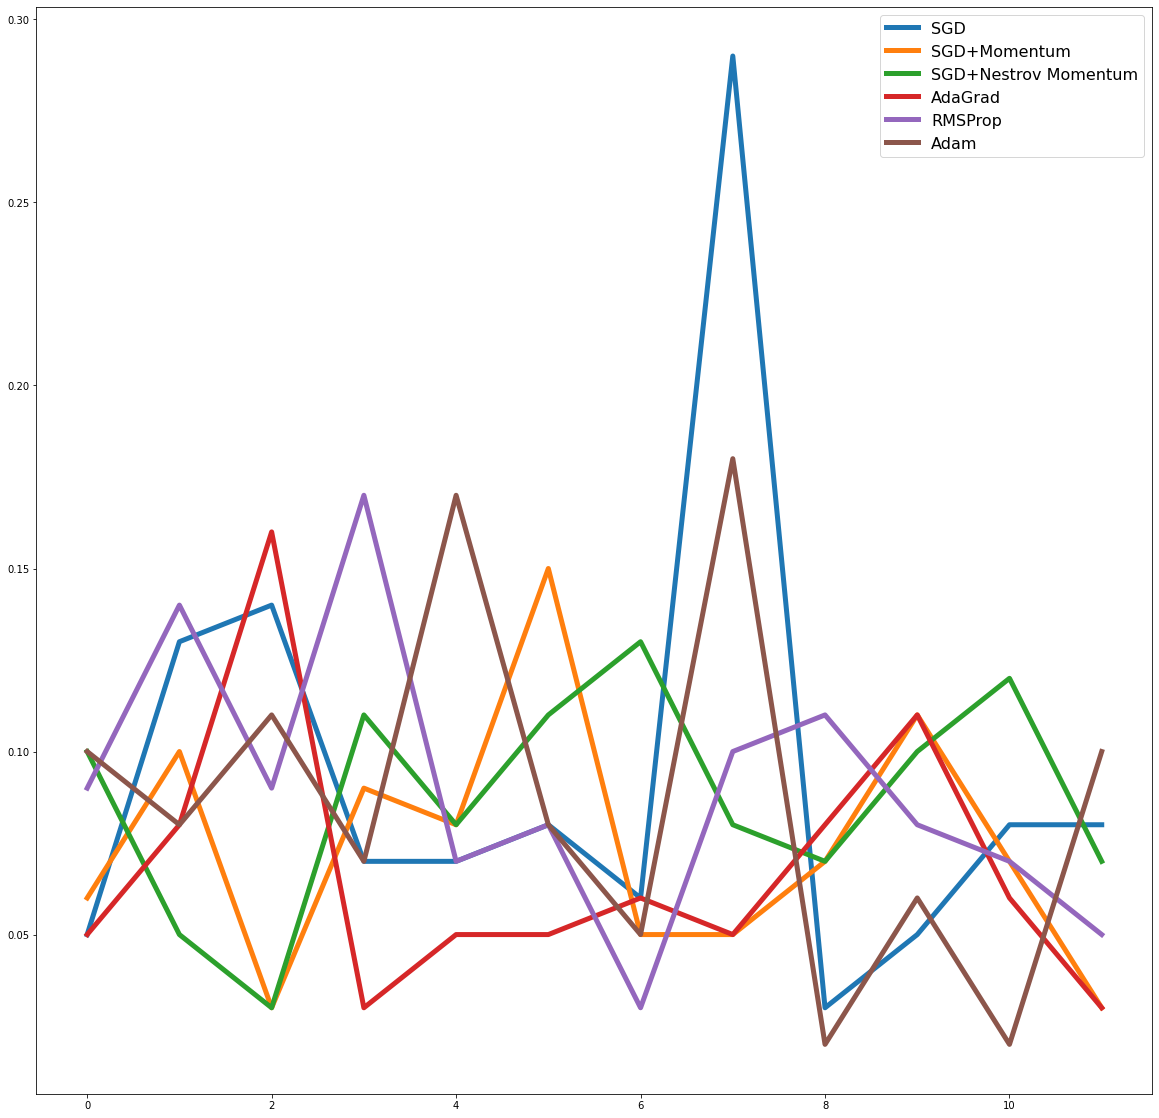

In [100]:
import numpy as np

idx_to_optimizer = {0: "SGD", 1: "SGD+Momentum", 2: "SGD+Nestrov Momentum", 3: "AdaGrad", 4: "RMSProp", 5: "Adam"}

plt.figure(figsize=(20, 20))

x = np.arange(len(idx_arr))
for idx, loss_arr in enumerate(selected_loss_arr_list):
    plt.plot(x, loss_arr, label = idx_to_optimizer[idx], linewidth = 5.0)

plt.legend(fontsize = 16)
plt.show()